# Phân tích và Xử lý Mất Cân Bằng Dữ Liệu Email

Notebook này thực hiện:
1. Phân tích dữ liệu email (phishing/benign)
2. Xử lý mất cân bằng dữ liệu bằng data augmentation
3. Chia dữ liệu thành Train/Validation/Test theo tỷ lệ 70-15-15

## Mục tiêu
- Tạo dataset cân bằng cho training
- Loại bỏ email quá dài (>512 từ)
- Augment dữ liệu để tăng số lượng samples
- Chia dữ liệu theo tỷ lệ chuẩn 


In [1]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random
from collections import Counter
from sklearn.model_selection import train_test_split

# NLTK imports
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

# WordCloud
from wordcloud import WordCloud

# Download NLTK data (chỉ cần chạy lần đầu)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

print("✓ Tất cả thư viện đã được import thành công!")


[nltk_data] Downloading package wordnet to C:\Users\batho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\batho/nltk_data...


✓ Tất cả thư viện đã được import thành công!


[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# SETUP - Thiết lập thư mục làm việc
root_dir = "D:\\BiiDenn\\PTITHCM\\Mon hoc\\HK9(2025-2026)\\DATN\\Graduation-Project"
os.chdir(root_dir)
print(f"Working directory: {os.getcwd()}")


Working directory: D:\BiiDenn\PTITHCM\Mon hoc\HK9(2025-2026)\DATN\DL-in-detecting-email-with-fake-content


## 1. Load và Phân tích Dữ liệu Ban đầu


In [3]:
# Load dữ liệu đã được xử lý
df = pd.read_csv("./data/processed/processed_combined.csv")

print("=" * 70)
print("Thông tin dữ liệu ban đầu")
print("=" * 70)
print(f"Tổng số dòng: {df.shape[0]}")
print(f"Tổng số cột: {df.shape[1]}")
print(f"\nCác cột: {df.columns.tolist()}")

print("\n" + "-" * 70)
print("Phân phối nhãn:")
print("-" * 70)
print(df['label'].value_counts())
print("\nTỷ lệ:")
print(df['label'].value_counts(normalize=True).map("{:.2%}".format))


Thông tin dữ liệu ban đầu
Tổng số dòng: 18202
Tổng số cột: 2

Các cột: ['label', 'text']

----------------------------------------------------------------------
Phân phối nhãn:
----------------------------------------------------------------------
label
1    9673
0    8529
Name: count, dtype: int64

Tỷ lệ:
label
1    53.14%
0    46.86%
Name: proportion, dtype: object


## 2. Chuẩn bị Training Data

Toàn bộ dữ liệu sẽ được sử dụng cho training và augmentation. 
Test set sẽ được tách ở bước cuối cùng theo tỷ lệ 70-15-15.


In [4]:
# Sử dụng toàn bộ dữ liệu cho training (test sẽ được tách ở bước cuối)
emails_train = df[['label', 'text']].copy().reset_index(drop=True)

print("=" * 70)
print("Training data")
print("=" * 70)
print(f"Tổng số samples: {len(emails_train)}")
print(f"Phân phối:")
print(emails_train['label'].value_counts())
print(f"\nTỷ lệ:")
print(emails_train['label'].value_counts(normalize=True).map("{:.2%}".format))


Training data
Tổng số samples: 18202
Phân phối:
label
1    9673
0    8529
Name: count, dtype: int64

Tỷ lệ:
label
1    53.14%
0    46.86%
Name: proportion, dtype: object


In [5]:
# Dữ liệu đã sẵn sàng cho các bước tiếp theo
print("✓ Dữ liệu đã sẵn sàng cho phân tích và augmentation")

✓ Dữ liệu đã sẵn sàng cho phân tích và augmentation


## 3. Phân tích Độ Dài Email


In [6]:
# Tính toán độ dài email (số từ và số ký tự)
emails_train['word_count'] = emails_train['text'].str.split().str.len()
emails_train['char_count'] = emails_train['text'].str.len()

print("=" * 70)
print("Thống kê độ dài email")
print("=" * 70)
print(f"Số từ - Min: {emails_train['word_count'].min()}, Max: {emails_train['word_count'].max()}, Mean: {emails_train['word_count'].mean():.2f}")
print(f"Số ký tự - Min: {emails_train['char_count'].min()}, Max: {emails_train['char_count'].max()}, Mean: {emails_train['char_count'].mean():.2f}")

# Đếm email có số từ > 512
emails_over_512 = emails_train[emails_train['word_count'] > 512]
print(f"\nSố email có > 512 từ: {len(emails_over_512)} ({len(emails_over_512)/len(emails_train)*100:.2f}%)")


Thống kê độ dài email
Số từ - Min: 1.0, Max: 26354.0, Mean: 366.56
Số ký tự - Min: 1.0, Max: 608231.0, Mean: 2590.40

Số email có > 512 từ: 3678 (20.21%)


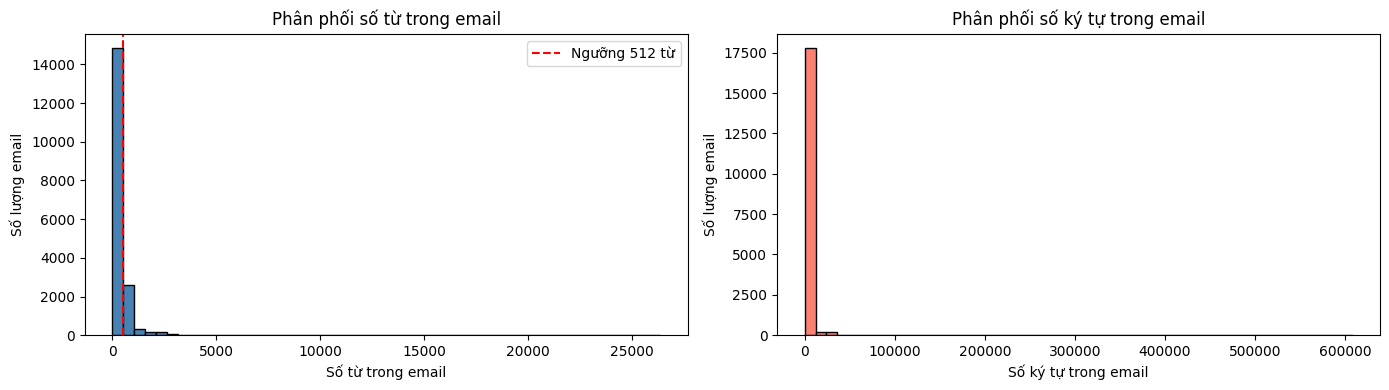

In [7]:
# Visualization độ dài email
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram số từ
axes[0].hist(emails_train['word_count'].dropna(), bins=50, color="steelblue", edgecolor="black")
axes[0].set_xlabel("Số từ trong email")
axes[0].set_ylabel("Số lượng email")
axes[0].set_title("Phân phối số từ trong email")
axes[0].axvline(x=512, color='red', linestyle='--', label='Ngưỡng 512 từ')
axes[0].legend()

# Histogram số ký tự
axes[1].hist(emails_train['char_count'].dropna(), bins=50, color="salmon", edgecolor="black")
axes[1].set_xlabel("Số ký tự trong email")
axes[1].set_ylabel("Số lượng email")
axes[1].set_title("Phân phối số ký tự trong email")

plt.tight_layout()
plt.show()


In [8]:
# Loại bỏ email có số từ > 512 (quá dài cho các mô hình)
df_filtered = emails_train[emails_train['word_count'] <= 512].copy()
df_filtered = df_filtered.drop(columns=['word_count', 'char_count'])

print("=" * 70)
print("Sau khi lọc email > 512 TỪ")
print("=" * 70)
print(f"Số email ban đầu: {len(emails_train)}")
print(f"Số email sau khi lọc: {len(df_filtered)}")
print(f"Đã loại bỏ: {len(emails_train) - len(df_filtered)} emails ({((len(emails_train) - len(df_filtered))/len(emails_train)*100):.2f}%)")
print(f"\nPhân phối label sau khi lọc:")
print(df_filtered['label'].value_counts())
print(f"\nTỷ lệ:")
print(df_filtered['label'].value_counts(normalize=True).map("{:.2%}".format))


Sau khi lọc email > 512 TỪ
Số email ban đầu: 18202
Số email sau khi lọc: 14522
Đã loại bỏ: 3680 emails (20.22%)

Phân phối label sau khi lọc:
label
0    7461
1    7061
Name: count, dtype: int64

Tỷ lệ:
label
0    51.38%
1    48.62%
Name: proportion, dtype: object


## 4. Phân tích Từ Vựng (Word Frequency Analysis)


In [9]:
# Chuẩn bị stopwords
stop_words = set(stopwords.words("english"))
extra_stopwords = {'s', 'http', 'https', 'www', 'net', 'etc', 'n', 't', 'com', 'e'}
all_stopwords = stop_words.union(extra_stopwords)

# Tách email theo label
phishing_emails = df_filtered.loc[df_filtered['label'] == 1, 'text']
ham_emails = df_filtered.loc[df_filtered['label'] == 0, 'text']

# Hàm đếm tần suất từ
def count_word_frequencies(email_series):
    """Đếm tần suất xuất hiện của các từ trong email series"""
    word_counter = Counter()
    for text in email_series.dropna():
        # Chỉ lấy các từ chữ cái (a-z), chuyển về chữ thường
        words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
        # Loại bỏ stopwords
        words = [w for w in words if w not in all_stopwords]
        word_counter.update(words)
    return word_counter

# Đếm tần suất từ
print("Đang đếm tần suất từ...")
phishing_words = count_word_frequencies(phishing_emails)
ham_words = count_word_frequencies(ham_emails)

print("✓ Hoàn thành!")


Đang đếm tần suất từ...
✓ Hoàn thành!


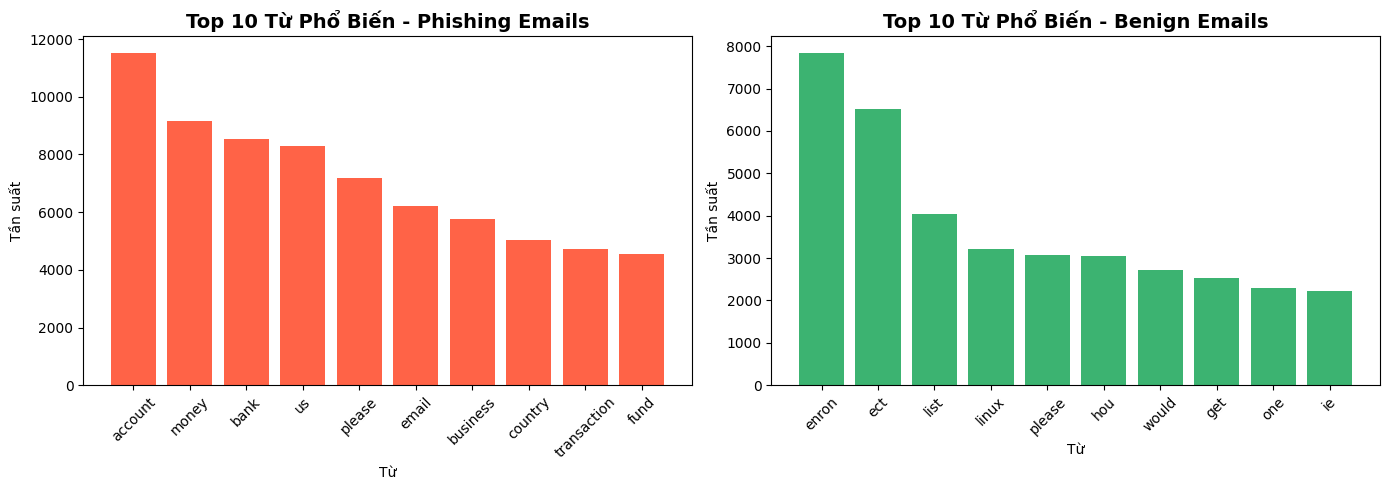

In [10]:
# Hiển thị 10 từ phổ biến nhất
phishing_common = phishing_words.most_common(10)
ham_common = ham_words.most_common(10)

phishing_common_df = pd.DataFrame(phishing_common, columns=['Word', 'Frequency'])
ham_common_df = pd.DataFrame(ham_common, columns=['Word', 'Frequency'])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top words trong Phishing emails
axes[0].bar(phishing_common_df['Word'], phishing_common_df['Frequency'], color='tomato')
axes[0].set_title('Top 10 Từ Phổ Biến - Phishing Emails', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Từ')
axes[0].set_ylabel('Tần suất')
axes[0].tick_params(axis='x', rotation=45)

# Top words trong Ham emails
axes[1].bar(ham_common_df['Word'], ham_common_df['Frequency'], color='mediumseagreen')
axes[1].set_title('Top 10 Từ Phổ Biến - Benign Emails', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Từ')
axes[1].set_ylabel('Tần suất')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


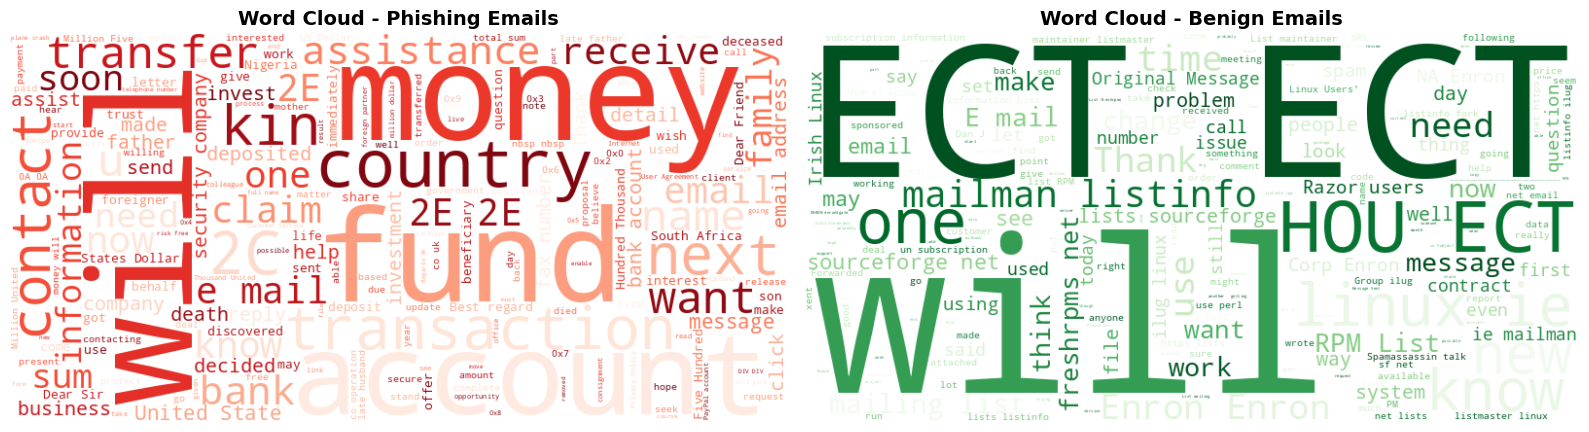

In [11]:
# Tạo WordCloud
def generate_wordcloud(text_series, colormap, title):
    """Tạo wordcloud từ text series"""
    text = ' '.join(text_series.dropna())
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap,
        max_words=200,
        contour_color='black',
        contour_width=1
    ).generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14, fontweight='bold')

# Visualization WordCloud
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
generate_wordcloud(phishing_emails, 'Reds', 'Word Cloud - Phishing Emails')

plt.subplot(1, 2, 2)
generate_wordcloud(ham_emails, 'Greens', 'Word Cloud - Benign Emails')

plt.tight_layout()
plt.show()


## 5. Định nghĩa Các Hàm Data Augmentation


In [12]:
# DATA AUGMENTATION FUNCTIONS

def get_synonyms(word):
    """Lấy các từ đồng nghĩa của một từ"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            s = lemma.name().replace("_", " ")
            if s.lower() != word.lower() and len(s.split()) == 1:
                synonyms.add(s)
    return list(synonyms)

def synonym_replacement(words, n=1):
    """Thay thế n từ bằng từ đồng nghĩa"""
    new_words = words.copy()
    candidates = list(set([w for w in words if w.isalpha() and len(w) > 2]))
    random.shuffle(candidates)
    count = 0
    for word in candidates:
        syns = get_synonyms(word)
        if syns:
            new_words = [random.choice(syns) if w == word else w for w in new_words]
            count += 1
        if count >= n:
            break
    return new_words

def add_word(new_words):
    """Thêm một từ ngẫu nhiên vào danh sách"""
    if not new_words:
        return
    for _ in range(10):
        word = random.choice(new_words)
        syns = get_synonyms(word)
        if syns:
            new_words.insert(random.randint(0, len(new_words)), syns[0])
            break

def random_deletion(words, p=0.15):
    """Xóa ngẫu nhiên các từ với xác suất p"""
    if len(words) <= 3:
        return words
    return [w for w in words if random.random() > p] or [random.choice(words)]

def random_insertion(words, n=1):
    """Chèn n từ ngẫu nhiên"""
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def random_swap(words, n=1):
    """Hoán đổi vị trí n cặp từ"""
    new_words = words.copy()
    for _ in range(n):
        if len(new_words) < 2:
            break
        i1 = random.randint(0, len(new_words) - 1)
        i2 = i1
        while i2 == i1:
            i2 = random.randint(0, len(new_words) - 1)
        new_words[i1], new_words[i2] = new_words[i2], new_words[i1]
    return new_words

def character_level_noise(words, p=0.08):
    """Thêm nhiễu ở mức ký tự"""
    out = []
    for w in words:
        if random.random() < p and len(w) > 3:
            if random.random() < 0.5:
                pos = random.randint(0, len(w))
                w = w[:pos] + random.choice('abcdefghijklmnopqrstuvwxyz') + w[pos:]
            else:
                pos = random.randint(0, len(w) - 1)
                w = w[:pos] + w[pos+1:]
        out.append(w)
    return out

def word_repetition(words, p=0.05):
    """Lặp lại từ với xác suất p"""
    out = []
    for w in words:
        out.append(w)
        if random.random() < p and len(w) > 3:
            out.append(w)
    return out

def augment_sentence(sentence):
    """Áp dụng nhiều kỹ thuật augmentation cho một câu"""
    words = sentence.split()
    if len(words) < 4:
        return sentence
    
    num_words = len(words)
    techniques_applied = 0

    # Áp dụng nhiều kỹ thuật với xác suất khác nhau
    if random.random() < 0.55:
        words = synonym_replacement(words, max(1, int(0.15 * num_words)))
        techniques_applied += 1

    if random.random() < 0.45:
        words = random_insertion(words, max(1, int(0.08 * num_words)))
        techniques_applied += 1

    if random.random() < 0.5:
        words = random_deletion(words, 0.12)
        techniques_applied += 1

    if random.random() < 0.5:
        words = random_swap(words, max(1, int(0.15 * num_words)))
        techniques_applied += 1

    if random.random() < 0.15:
        words = character_level_noise(words)
        techniques_applied += 1

    if random.random() < 0.1:
        words = word_repetition(words)
        techniques_applied += 1

    # Đảm bảo ít nhất một kỹ thuật được áp dụng
    if techniques_applied == 0:
        technique = random.choice(['synonym', 'swap', 'deletion'])
        if technique == 'synonym':
            words = synonym_replacement(words, max(1, int(0.1 * num_words)))
        elif technique == 'swap':
            words = random_swap(words, max(1, int(0.1 * num_words)))
        else:
            words = random_deletion(words, 0.1)

    return ' '.join(words)

print("✓ Tất cả các hàm augmentation đã được định nghĩa!")


✓ Tất cả các hàm augmentation đã được định nghĩa!


## 6. Xử lý Mất Cân Bằng và Data Augmentation


In [13]:
# Loại bỏ duplicates trước khi augment
df_filtered = df_filtered.drop_duplicates()

print("=" * 70)
print("Sau khi loại bỏ duplicates")
print("=" * 70)
print(f"Tổng số samples: {len(df_filtered)}")
print(f"Phân phối:")
print(df_filtered['label'].value_counts())
print(f"\nTỷ lệ:")
print(df_filtered['label'].value_counts(normalize=True).map("{:.2%}".format))


Sau khi loại bỏ duplicates
Tổng số samples: 13794
Phân phối:
label
0    7439
1    6355
Name: count, dtype: int64

Tỷ lệ:
label
0    53.93%
1    46.07%
Name: proportion, dtype: object


In [14]:
# Tách dữ liệu theo label và loại bỏ duplicates
df_emails_ham = df_filtered[df_filtered['label'] == 0].drop_duplicates(subset=['text']).reset_index(drop=True)
df_emails_phishing = df_filtered[df_filtered['label'] == 1].drop_duplicates(subset=['text']).reset_index(drop=True)

# Mục tiêu: 10000 ham, 9500 phishing
target_ham = 10000
target_phishing = 9500

num_of_additional_ham = target_ham - len(df_emails_ham)
num_of_additional_phishing = target_phishing - len(df_emails_phishing)

print("=" * 70)
print("Kế hoạch Augmentation")
print("=" * 70)
print(f"Benign hiện tại: {len(df_emails_ham)}")
print(f"Phishing hiện tại: {len(df_emails_phishing)}")
print(f"\nCần tạo thêm:")
print(f"  - Benign: {num_of_additional_ham} samples")
print(f"  - Phishing: {num_of_additional_phishing} samples")


Kế hoạch Augmentation
Benign hiện tại: 7439
Phishing hiện tại: 6355

Cần tạo thêm:
  - Benign: 2561 samples
  - Phishing: 3145 samples


In [15]:
# HÀM AUGMENTATION CHO HAM EMAILS

def generate_unique_augmented_ham(ham_texts, target_count):
    """Tạo các email ham đã được augment, đảm bảo unique"""
    existing_texts = set(ham_texts)
    augmented_texts = set()
    ham_list = ham_texts.tolist()

    attempts = 0
    max_attempts = target_count * 60

    while len(augmented_texts) < target_count and attempts < max_attempts:
        original_text = random.choice(ham_list)
        augmented_text = augment_sentence(original_text)

        # Kiểm tra điều kiện chấp nhận
        if (
            augmented_text not in existing_texts
            and augmented_text not in augmented_texts
            and augmented_text != original_text
            and len(augmented_text.strip()) > 10
            and len(augmented_text.split()) >= 3
        ):
            augmented_texts.add(augmented_text)
            existing_texts.add(augmented_text)

        attempts += 1

    print(f"Generated {len(augmented_texts)}/{target_count} augmented sentences after {attempts} attempts")

    # Fallback: tạo các biến thể nhẹ nếu chưa đủ
    if len(augmented_texts) < target_count:
        need_more = target_count - len(augmented_texts)
        print(f"Filling {need_more} remaining with safe variations.")

        base_pool = list(augmented_texts) if augmented_texts else ham_list
        punctuation_pool = ["!", ".", "??", "~", "...", " -", ",", ";"]
        alphabet = 'abcdefghijklmnopqrstuvwxyz'

        idx = 0
        while len(augmented_texts) < target_count:
            base = base_pool[idx % len(base_pool)]
            idx += 1
            noise = ''.join(random.choice(alphabet) for _ in range(2))
            variation = f"{base} {random.choice(punctuation_pool)}{noise}"

            if variation not in existing_texts:
                augmented_texts.add(variation)
                existing_texts.add(variation)

    return list(augmented_texts)

print("✓ Hàm augmentation cho Ham emails đã sẵn sàng!")


✓ Hàm augmentation cho Ham emails đã sẵn sàng!


In [16]:
# HÀM AUGMENTATION CHO PHISHING EMAILS

def generate_unique_augmented_phishing(phishing_texts, target_count):
    """Tạo các email phishing đã được augment, đảm bảo vẫn mang tính phishing"""
    existing_texts = set(phishing_texts)
    augmented_texts = set()
    phishing_list = phishing_texts.tolist()

    # Các từ khóa phishing
    phishing_cues = [
        "account", "verify", "confirm", "bank", "password", "urgent", "login",
        "alert", "security", "update", "verification", "identity", "credentials",
        "restricted", "locked", "support", "review", "attention", "important"
    ]

    # Các pattern câu phishing
    phishing_patterns = [
        "please verify your identity immediately",
        "your account requires urgent attention",
        "security alert: unusual activity detected",
        "your password must be updated to continue",
        "your access has been temporarily restricted",
        "immediate verification is required",
        "your login information appears compromised",
        "we detected suspicious activity in your account",
        "your account will be locked if not confirmed",
        "your credentials need verification",
        "security update is pending for your account",
        "this is an important notice regarding your account"
    ]

    def ensure_phishing_cue(text):
        """Đảm bảo text có chứa từ khóa phishing"""
        lower = text.lower()
        if any(cue in lower for cue in phishing_cues):
            return text
        words = text.split()
        insert_pos = random.randint(1, max(1, len(words) - 1))
        cue = random.choice(phishing_cues)
        words.insert(insert_pos, cue)
        return " ".join(words)

    def apply_soft_phishing_pattern(text):
        """Thêm pattern phishing vào cuối câu (tùy chọn)"""
        if random.random() < 0.40:
            pattern = random.choice(phishing_patterns)
            return f"{text}. {pattern}"
        return text

    attempts = 0
    max_attempts = target_count * 60

    while len(augmented_texts) < target_count and attempts < max_attempts:
        original_text = random.choice(phishing_list)
        augmented_text = augment_sentence(original_text)
        augmented_text = ensure_phishing_cue(augmented_text)
        augmented_text = apply_soft_phishing_pattern(augmented_text)

        # Kiểm tra điều kiện chấp nhận
        if (
            augmented_text not in existing_texts
            and augmented_text not in augmented_texts
            and augmented_text != original_text
            and len(augmented_text.strip()) > 10
            and len(augmented_text.split()) >= 4
        ):
            augmented_texts.add(augmented_text)
            existing_texts.add(augmented_text)

        attempts += 1

    print(f"[Main] Generated {len(augmented_texts)}/{target_count} after {attempts} attempts.")

    # Fallback
    if len(augmented_texts) < target_count:
        need_more = target_count - len(augmented_texts)
        print(f"[Fallback] Filling the remaining: {need_more}")

        base_pool = list(augmented_texts) if augmented_texts else phishing_list
        punctuation_pool = ["!", ".", "...", "??", ";"]
        alphabet = "abcdefghijklmnopqrstuvwxyz"

        idx = 0
        while len(augmented_texts) < target_count:
            base = base_pool[idx % len(base_pool)]
            idx += 1
            noise = ''.join(random.choice(alphabet) for _ in range(2))
            variation = f"{base}{random.choice(punctuation_pool)}{noise}"
            variation = ensure_phishing_cue(variation)
            variation = apply_soft_phishing_pattern(variation)

            if variation not in existing_texts:
                augmented_texts.add(variation)
                existing_texts.add(variation)

    return list(augmented_texts)

print("✓ Hàm augmentation cho Phishing emails đã sẵn sàng!")


✓ Hàm augmentation cho Phishing emails đã sẵn sàng!


In [17]:
# Tạo augmented data cho Ham emails
print("Đang tạo augmented data cho Benign emails...")
augmented_ham = generate_unique_augmented_ham(
    df_emails_ham['text'], 
    num_of_additional_ham
)
print("✓ Hoàn thành!\n")

# Tạo augmented data cho Phishing emails
print("Đang tạo augmented data cho Phishing emails...")
augmented_phishing = generate_unique_augmented_phishing(
    df_emails_phishing['text'], 
    num_of_additional_phishing
)
print("✓ Hoàn thành!")


Đang tạo augmented data cho Benign emails...
Generated 2561/2561 augmented sentences after 2587 attempts
✓ Hoàn thành!

Đang tạo augmented data cho Phishing emails...
[Main] Generated 3145/3145 after 3152 attempts.
✓ Hoàn thành!


In [18]:
# Gộp dữ liệu gốc và augmented
df_ham_augmented = pd.DataFrame({
    'text': augmented_ham, 
    'label': 0
})

df_phishing_augmented = pd.DataFrame({
    'text': augmented_phishing, 
    'label': 1
})

# Gộp với dữ liệu gốc
df_emails_ham_selected = pd.concat([
    df_emails_ham[['text', 'label']],
    df_ham_augmented
]).reset_index(drop=True)

df_emails_phishing_selected = pd.concat([
    df_emails_phishing[['text', 'label']],
    df_phishing_augmented
]).reset_index(drop=True)

# Tạo training set cuối cùng
train_final = pd.concat([
    df_emails_ham_selected, 
    df_emails_phishing_selected
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("=" * 70)
print("Training set sau augmentation")
print("=" * 70)
print(f"Tổng số samples: {len(train_final)}")
print(f"Phân phối:")
print(train_final['label'].value_counts())
print(f"\nTỷ lệ:")
print(train_final['label'].value_counts(normalize=True).map('{:.2%}'.format))
print(f"\nDuplicates: {train_final.duplicated().sum()}")


Training set sau augmentation
Tổng số samples: 19500
Phân phối:
label
0    10000
1     9500
Name: count, dtype: int64

Tỷ lệ:
label
0    51.28%
1    48.72%
Name: proportion, dtype: object

Duplicates: 0


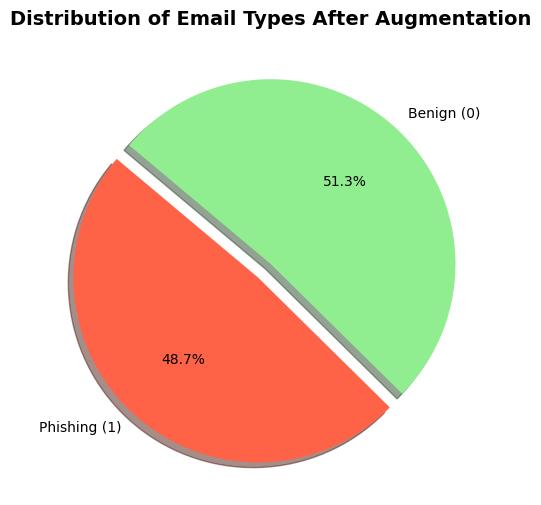

In [19]:
# Visualization phân phối sau augmentation
email_counts = train_final['label'].value_counts().reindex([1, 0], fill_value=0)
labels = ['Phishing (1)', 'Benign (0)']
colors = ['tomato', 'lightgreen']

plt.figure(figsize=(7, 6))
plt.pie(
    np.array(email_counts),
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=(0.1, 0),
    shadow=True
)
plt.title('Distribution of Email Types After Augmentation', fontsize=14, fontweight='bold')
plt.show()


## 7. Chia Dữ liệu theo Tỷ lệ 70-15-15 (Train-Validation-Test)

Sau khi đã tạo `train_final` (sau augmentation), chúng ta sẽ chia thành 3 tập:
- **Train**: 70%
- **Validation**: 15%  
- **Test**: 15%

Điều này đảm bảo tất cả các model sử dụng cùng một tập validation và test để so sánh công bằng.


In [20]:
# Sử dụng train_final (đã được augmentation) để chia thành train/val/test
df_combined = train_final.copy()

# Xáo trộn để đảm bảo phân phối ngẫu nhiên
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print("=" * 70)
print("Dataset trước khi chia")
print("=" * 70)
print(f"Tổng số samples: {df_combined.shape[0]}")
print(f"\nPhân phối label:")
print(df_combined['label'].value_counts())
print(f"\nTỷ lệ:")
print(df_combined['label'].value_counts(normalize=True).map('{:.2%}'.format))


Dataset trước khi chia
Tổng số samples: 19500

Phân phối label:
label
0    10000
1     9500
Name: count, dtype: int64

Tỷ lệ:
label
0    51.28%
1    48.72%
Name: proportion, dtype: object


In [21]:
# Chia dữ liệu theo tỷ lệ 70-15-15
# Đảm bảo không có trùng lặp về nội dung text giữa các tập

# Loại bỏ duplicates trước khi chia (đảm bảo mỗi text chỉ xuất hiện 1 lần)
df_combined_unique = df_combined.drop_duplicates(subset=['text']).reset_index(drop=True)

print("=" * 70)
print("Kiểm tra trước khi chia")
print("=" * 70)
print(f"Tổng số samples trước khi loại duplicates: {len(df_combined)}")
print(f"Tổng số samples sau khi loại duplicates: {len(df_combined_unique)}")
print(f"Đã loại bỏ: {len(df_combined) - len(df_combined_unique)} duplicates")

X = df_combined_unique['text']
y = df_combined_unique['label']

# Bước 1: Tách train (70%) và temp (30%)
X_train_new, X_temp, y_train_new, y_temp = train_test_split(
    X, y,
    test_size=0.3,  # 30% cho validation + test
    stratify=y,  # Giữ tỷ lệ class cân bằng
    random_state=42
)

# Bước 2: Chia temp thành validation (15%) và test (15%)
X_val, X_test_new, y_val, y_test_new = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # Chia đôi temp thành 15% + 15%
    stratify=y_temp,  # Giữ tỷ lệ class cân bằng
    random_state=42
)

# Đảm bảo không có text trùng lặp giữa các tập
train_texts_set = set(X_train_new.astype(str))
val_texts_set = set(X_val.astype(str))
test_texts_set = set(X_test_new.astype(str))

overlap_train_val = train_texts_set.intersection(val_texts_set)
overlap_train_test = train_texts_set.intersection(test_texts_set)
overlap_val_test = val_texts_set.intersection(test_texts_set)

print("\n" + "=" * 70)
print("Kết quả chia dữ liệu")
print("=" * 70)
print(f"Train size: {len(X_train_new)} ({len(X_train_new)/len(df_combined_unique)*100:.2f}%)")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(df_combined_unique)*100:.2f}%)")
print(f"Test size: {len(X_test_new)} ({len(X_test_new)/len(df_combined_unique)*100:.2f}%)")
print(f"\nTổng: {len(X_train_new) + len(X_val) + len(X_test_new)}")

print("\n" + "=" * 70)
print("Kiểm tra trùng lặp sau khi chia")
print("=" * 70)
print(f"Train vs Validation: {len(overlap_train_val)} text trùng")
print(f"Train vs Test: {len(overlap_train_test)} text trùng")
print(f"Validation vs Test: {len(overlap_val_test)} text trùng")

if len(overlap_train_val) == 0 and len(overlap_train_test) == 0 and len(overlap_val_test) == 0:
    print("\n✅ ĐẢM BẢO: Không có text trùng lặp giữa các tập!")
else:
    print("\n⚠️  CẢNH BÁO: Có text trùng lặp! (Điều này không nên xảy ra với train_test_split)")


Kiểm tra trước khi chia
Tổng số samples trước khi loại duplicates: 19500
Tổng số samples sau khi loại duplicates: 19498
Đã loại bỏ: 2 duplicates

Kết quả chia dữ liệu
Train size: 13648 (70.00%)
Validation size: 2925 (15.00%)
Test size: 2925 (15.00%)

Tổng: 19498

Kiểm tra trùng lặp sau khi chia
Train vs Validation: 0 text trùng
Train vs Test: 0 text trùng
Validation vs Test: 0 text trùng

✅ ĐẢM BẢO: Không có text trùng lặp giữa các tập!


In [22]:
# Kiểm tra phân phối label trong từng tập
print("=" * 70)
print("Phân phối label trong từng tập")
print("=" * 70)

print("\nTRAIN SET:")
print(y_train_new.value_counts())
print(y_train_new.value_counts(normalize=True).map('{:.2%}'.format))

print("\nVALIDATION SET:")
print(y_val.value_counts())
print(y_val.value_counts(normalize=True).map('{:.2%}'.format))

print("\nTEST SET:")
print(y_test_new.value_counts())
print(y_test_new.value_counts(normalize=True).map('{:.2%}'.format))


Phân phối label trong từng tập

TRAIN SET:
label
0    6998
1    6650
Name: count, dtype: int64
label
0    51.27%
1    48.73%
Name: proportion, dtype: object

VALIDATION SET:
label
0    1500
1    1425
Name: count, dtype: int64
label
0    51.28%
1    48.72%
Name: proportion, dtype: object

TEST SET:
label
0    1500
1    1425
Name: count, dtype: int64
label
0    51.28%
1    48.72%
Name: proportion, dtype: object


In [23]:
# Tạo DataFrame và lưu file
df_train_final = pd.DataFrame({
    'text': X_train_new.values,
    'label': y_train_new.values
})

df_val_final = pd.DataFrame({
    'text': X_val.values,
    'label': y_val.values
})

df_test_final = pd.DataFrame({
    'text': X_test_new.values,
    'label': y_test_new.values
})

# Lưu các file
output_dir = './data/final'
os.makedirs(output_dir, exist_ok=True)

df_train_final.to_csv(f'{output_dir}/final_train.csv', index=False, escapechar='\\')
df_val_final.to_csv(f'{output_dir}/final_val.csv', index=False, escapechar='\\')
df_test_final.to_csv(f'{output_dir}/final_test.csv', index=False, escapechar='\\')

print("=" * 70)
print("ĐÃ LƯU CÁC FILE")
print("=" * 70)
print(f"✓ {output_dir}/final_train.csv ({len(df_train_final)} samples)")
print(f"✓ {output_dir}/final_val.csv ({len(df_val_final)} samples)")
print(f"✓ {output_dir}/final_test.csv ({len(df_test_final)} samples)")


ĐÃ LƯU CÁC FILE
✓ ./data/final/final_train.csv (13648 samples)
✓ ./data/final/final_val.csv (2925 samples)
✓ ./data/final/final_test.csv (2925 samples)


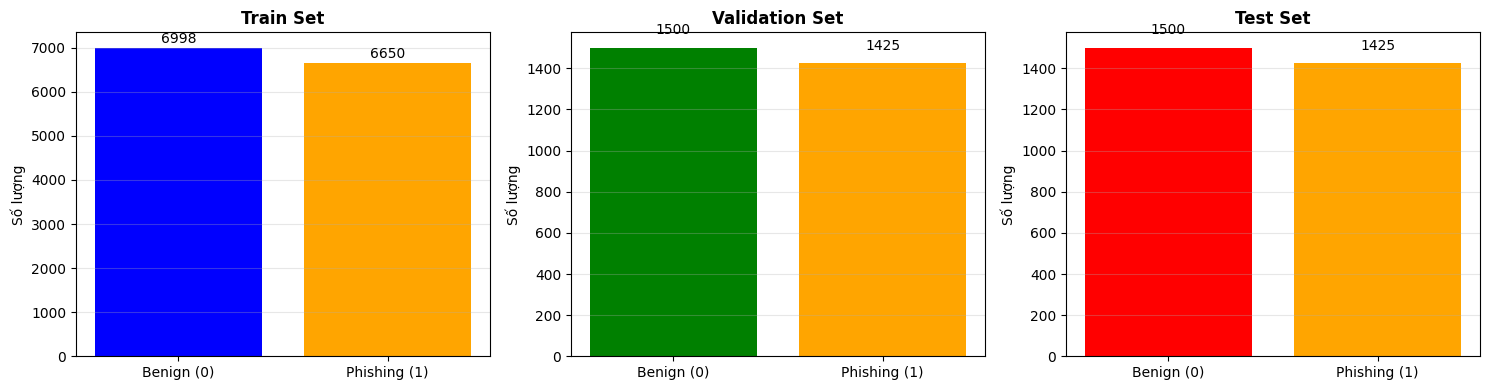

✓ Đã lưu biểu đồ: ./output/figures/train_val_test_distribution.png


In [24]:
# Visualization phân phối dữ liệu
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    (y_train_new, 'Train Set', 'blue'),
    (y_val, 'Validation Set', 'green'),
    (y_test_new, 'Test Set', 'red')
]

for idx, (labels, title, color) in enumerate(datasets):
    counts = labels.value_counts().reindex([0, 1], fill_value=0)
    categories = ['Benign (0)', 'Phishing (1)']
    
    axes[idx].bar(categories, counts.values, color=[color, 'orange'])
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Thêm số lượng lên trên mỗi cột
    for i, count in enumerate(counts.values):
        axes[idx].text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
os.makedirs('./output/figures', exist_ok=True)
plt.savefig('./output/figures/train_val_test_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Đã lưu biểu đồ: ./output/figures/train_val_test_distribution.png")


In [25]:
# Tóm tắt kết quả cuối cùng
print("=" * 70)
print("TÓM TẮT CHIA DỮ LIỆU")
print("=" * 70)

# Tính tổng dựa trên chính các tập đã chia để tránh lệch 2 mẫu
total = len(X_train_new) + len(X_val) + len(X_test_new)
total_benign = (y_train_new == 0).sum() + (y_val == 0).sum() + (y_test_new == 0).sum()
total_phishing = (y_train_new == 1).sum() + (y_val == 1).sum() + (y_test_new == 1).sum()

summary = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [len(X_train_new), len(X_val), len(X_test_new), total],
    'Percentage': [
        f"{len(X_train_new)/total*100:.2f}%",
        f"{len(X_val)/total*100:.2f}%",
        f"{len(X_test_new)/total*100:.2f}%",
        '100%'
    ],
    'Benign': [
        (y_train_new == 0).sum(),
        (y_val == 0).sum(),
        (y_test_new == 0).sum(),
        total_benign
    ],
    'Phishing': [
        (y_train_new == 1).sum(),
        (y_val == 1).sum(),
        (y_test_new == 1).sum(),
        total_phishing
    ]
})

print("\n")
print(summary.to_string(index=False))

print("\n" + "=" * 70)
print("Các file được lưu:")
print("=" * 70)
print("1. ./data/final/final_train.csv")
print("2. ./data/final/final_val.csv")
print("3. ./data/final/final_test.csv")
print("\n" + "=" * 70)
print("Lưu ý:")
print("=" * 70)
print("Các model notebooks cần được cập nhật để load validation từ file riêng.")
print("Thay vì dùng train_test_split trong model notebooks, hãy load:")
print("  - Train: data/final/final_train.csv")
print("  - Validation: data/final/final_val.csv")
print("  - Test: data/final/final_test.csv")


TÓM TẮT CHIA DỮ LIỆU


   Dataset  Samples Percentage  Benign  Phishing
     Train    13648     70.00%    6998      6650
Validation     2925     15.00%    1500      1425
      Test     2925     15.00%    1500      1425
     Total    19498       100%    9998      9500

Các file được lưu:
1. ./data/final/final_train.csv
2. ./data/final/final_val.csv
3. ./data/final/final_test.csv

Lưu ý:
Các model notebooks cần được cập nhật để load validation từ file riêng.
Thay vì dùng train_test_split trong model notebooks, hãy load:
  - Train: data/final/final_train.csv
  - Validation: data/final/final_val.csv
  - Test: data/final/final_test.csv
